# Sentiment Analysis of Friends TV Show Scripts

---

- Sentiment analysis using:
  - afinn
  - bing
  - loughran
  - nrc
- Missing data techniques on combined sentiment data

## Package Imports and Data

---

In [1]:
# Package Imports
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import defaultdict
from sklearn.preprocessing import normalize
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

e:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
e:\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
nltk.download("punkt")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to C:\Users\Joey
[nltk_data]     Tang\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to C:\Users\Joey
[nltk_data]     Tang\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [3]:
# Script data
quotes = pd.read_csv("../data/friends_quotes.csv")
# read the sentiment analysis datasets
afinn = pd.read_csv("../data/afinn.csv", index_col=0)
bing = pd.read_csv("../data/bing.csv", index_col=0)
loughran = pd.read_csv("../data/loughran.csv",index_col=0)
nrc = pd.read_csv("../data/nrc.csv", index_col=0)


In [15]:
afinn

,word,value
1,abandon,-2
2,abandoned,-2
3,abandons,-2
4,abducted,-2
5,abduction,-2
...,...,...
2473,yucky,-2
2474,yummy,3
2475,zealot,-2
2476,zealots,-2


In [16]:
def fix_author_name(name):
    if isinstance(name, str) and name.isupper():
        return name.capitalize()
    return name

# Apply the fix
quotes['author'] = quotes['author'].apply(fix_author_name)

In [17]:
main_characters = ['Joey', 'Phoebe', 'Monica', 'Chandler', 'Ross', 'Rachel']
supporting_roles = ['Susan','Mrs. Geller','Mr. Geller','Carol',
                    'Frank','Janice','Richard','David','Mike','Tag','Gunther']
quotes_main_characters = quotes[
    quotes["author"].isin(main_characters + supporting_roles)
].copy()
quotes_main_characters.head()

,author,episode_number,episode_title,quote,quote_order,season
0,Monica,1.0,Monica Gets A Roommate,There's nothing to tell! He's just some guy I ...,0.0,1.0
1,Joey,1.0,Monica Gets A Roommate,"C'mon, you're going out with the guy! There's ...",1.0,1.0
2,Chandler,1.0,Monica Gets A Roommate,"All right Joey, be nice. So does he have a hum...",2.0,1.0
3,Phoebe,1.0,Monica Gets A Roommate,"Wait, does he eat chalk?",3.0,1.0
4,Phoebe,1.0,Monica Gets A Roommate,"Just, 'cause, I don't want her to go through w...",4.0,1.0


## Sentiment Analysis

---

### AFINN

- Each Character's quotes are scored using the AFINN-111 sentiment analysis word list.
  - All seasons average score
  - Each season average score

Average score definition:

- If the quote contains a word from the AFINN-111 list
- quote_count += 1
- quote_score = all AFINN-111 words score / number of AFINN-111 words in the quote
- Average score = quote_score / quote_count


In [18]:
# Preprocess text
def simple_preprocess(text):
    if not isinstance(text, str) or text.lower() == 'nan':
        return []
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    return [word for word in tokens if word not in stop_words]

In [19]:
# Empty DataFrame for AFINN results
afinn_results = pd.DataFrame(
    columns=quotes_main_characters["season"].unique().tolist() + ["all_seasons"],
    index=main_characters + ["all_characters"]
)
afinn_results = afinn_results.astype(float).fillna(0)
afinn_results.index.name = "author"
afinn_results.columns.name = "season"

In [23]:
def get_quote_score(quote: str):
    """
    Get the AFINN score of a quote.
    """
    # Split the quote into words
    words = simple_preprocess(quote)
    # Get the AFINN score for each word
    scores = [afinn[afinn["word"] == word]["value"].values[0] for word in words if word in afinn["word"].values]
    # Calculate the average score
    if len(scores) > 0:
        return sum(scores) / len(scores)
    else:
        return None

quotes_score = quotes_main_characters[["author", "season", "quote"]].copy()
quotes_score["quote_score"] = quotes_score["quote"].apply(get_quote_score)
quotes_score.dropna(subset=["quote_score"], inplace=True)
quotes_score.head()


,author,season,quote,quote_score
1,Joey,1.0,"C'mon, you're going out with the guy! There's ...",-2.0
2,Chandler,1.0,"All right Joey, be nice. So does he have a hum...",3.0
4,Phoebe,1.0,"Just, 'cause, I don't want her to go through w...",1.0
6,Chandler,1.0,Sounds like a date to me.,2.0
12,Joey,1.0,Never had that dream.,1.0


<AxesSubplot:xlabel='season'>

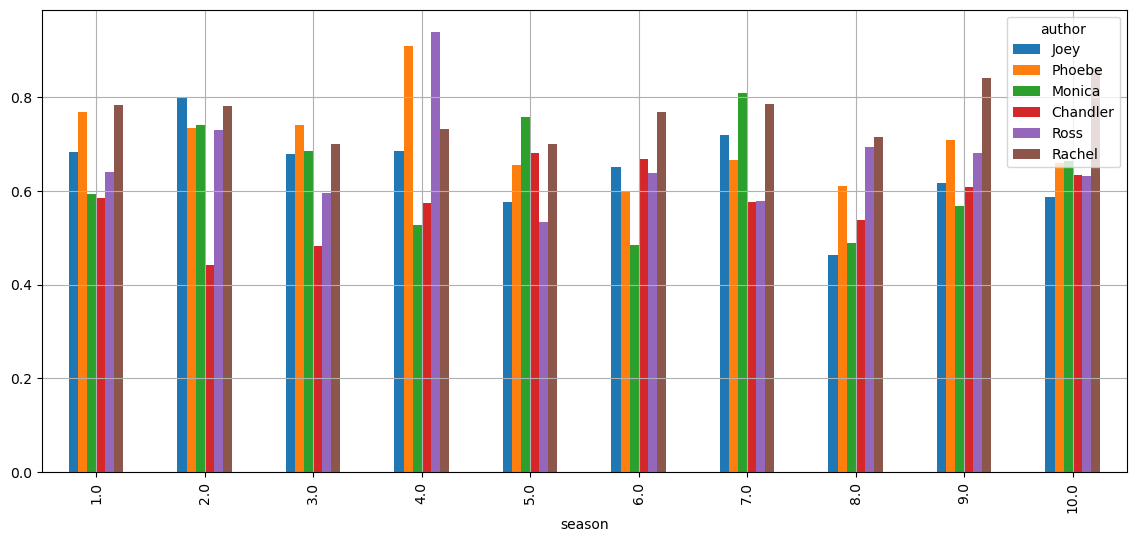

In [24]:
# pivot the quotes_score, index = name,  column = season, value = quote score, aggfunc = mean
quotes_score_pivot = quotes_score.pivot_table(
    index="author",
    columns="season",
    values="quote_score",
    aggfunc="mean",
)

quotes_score_pivot.loc[main_characters].T.plot(kind="bar", legend=True, figsize=(14, 6), grid=True)


In [25]:
character_emotion_afinn = quotes_score_pivot.mean(axis=1).sort_values(ascending=False)

<AxesSubplot:xlabel='season'>

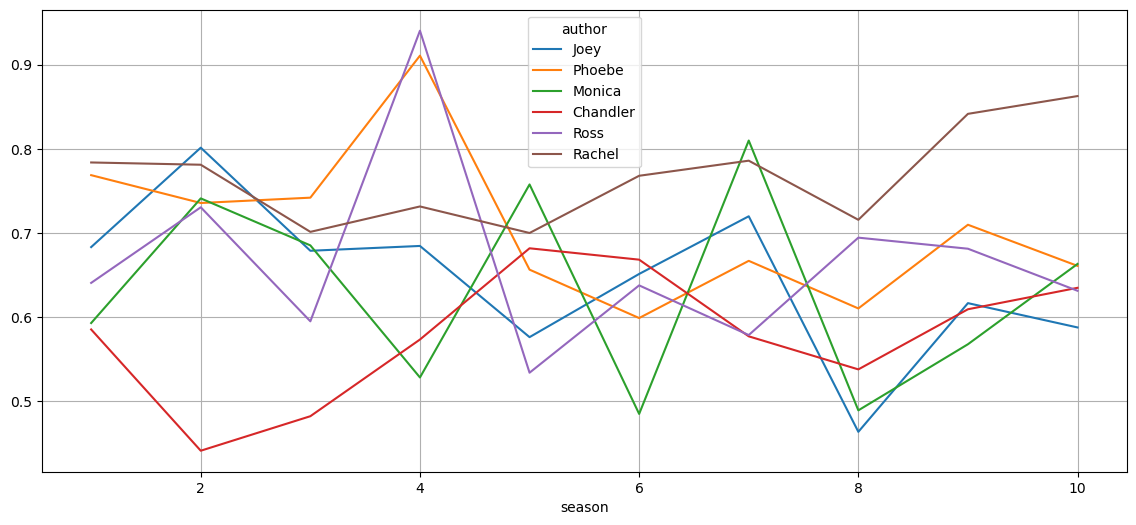

In [26]:
quotes_score_pivot.loc[main_characters].T.plot(legend=True, figsize=(14, 6), grid=True)

<AxesSubplot:xlabel='season'>

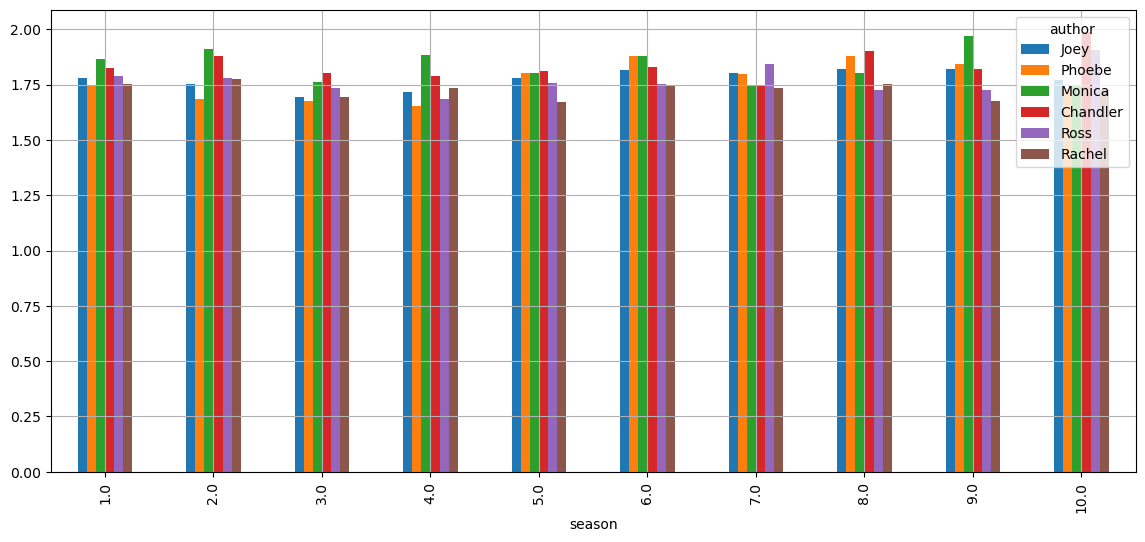

In [27]:
# pivot the quotes_score, index = name,  column = season, value = quote count
quotes_std = quotes_score.pivot_table(
    index="author",
    columns="season",
    values="quote_score",
    aggfunc="std"
)

quotes_std.loc[main_characters].T.plot(kind="bar", legend=True, figsize=(14, 6), grid=True)

<AxesSubplot:xlabel='season'>

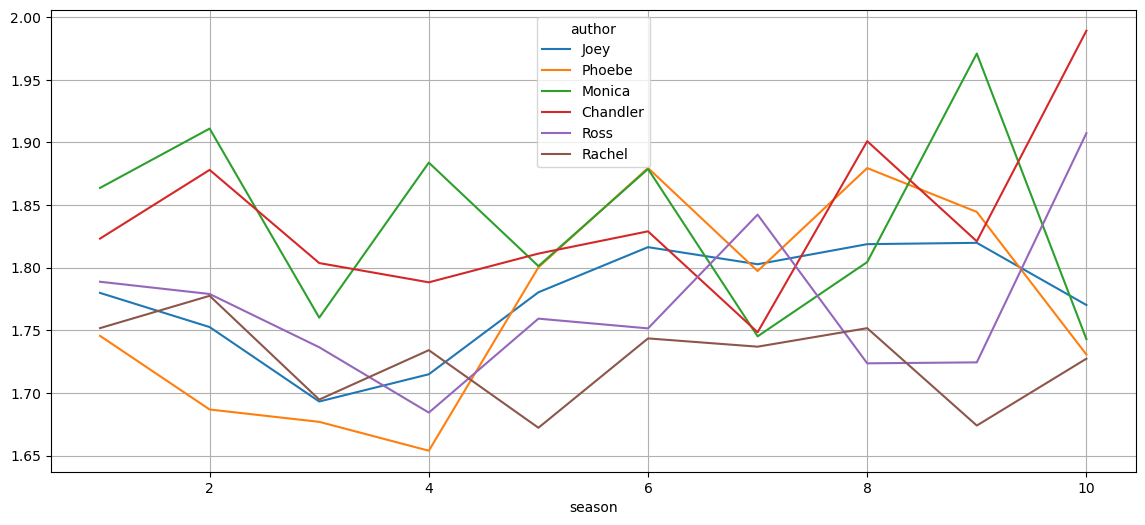

In [28]:
quotes_std.loc[main_characters].T.plot(legend=True, figsize=(14, 6), grid=True)

### Bing Liu's opinion lexicon sentiment word list
- Each Character's quotes are scored using the Loughran-McDonald sentiment analysis word list.
  - All seasons average score in ['positive', 'negative']

Emotion ratio definition:

- If the quote contains a word from the Bing Liu list
- quote_count += 1
- author_emotion += 1
- author_emothion_ratio = author_emotion_count / quote_count

In [29]:
# Prepare BL dictionary
bl_emotions = bing[['word', 'sentiment']].copy()
bl_emotions['word'] = bl_emotions['word'].str.lower()
bl_dict = defaultdict(set)
for _, row in bl_emotions.iterrows():
    bl_dict[row['word']].add(row['sentiment'])

In [30]:
# Build emotional profile
emotion_categories = sorted(set(bl_emotions['sentiment']))
character_emotion_counts = defaultdict(lambda: defaultdict(int))

for _, row in quotes_main_characters.iterrows():
    quote = row.get('quote', '')
    if not isinstance(quote, str) or quote.strip().lower() == 'nan':
        continue
    author = row['author']
    words = simple_preprocess(quote)
    for word in words:
        if word in bl_dict:
            for emotion in bl_dict[word]:
                character_emotion_counts[author][emotion] += 1

# Emotion DataFrame
character_emotion_df = pd.DataFrame(character_emotion_counts).T.fillna(0)

character_emotion_df = character_emotion_df[character_emotion_df.sum(axis=1) != 0]

character_emotion_normalized = pd.DataFrame(
    character_emotion_df/character_emotion_df.sum(axis=1).values[:, np.newaxis],
    index=character_emotion_df.index,
    columns=character_emotion_df.columns
)




<AxesSubplot:>

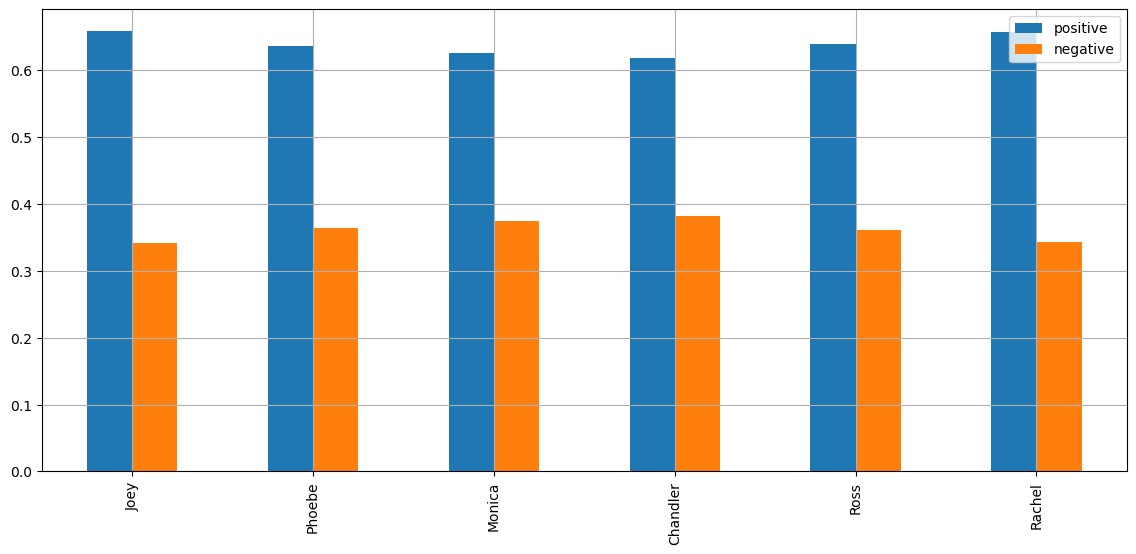

In [31]:
character_emotion_bl = character_emotion_normalized.loc[main_characters+supporting_roles].copy()
character_emotion_bl.loc[main_characters].plot(kind="bar", legend=True, figsize=(14, 6), grid=True)

### Loughran-McDonald sentiment word list
- Each Character's quotes are scored using the Loughran-McDonald sentiment analysis word list.
  - All seasons average score in ['constraining','litigious','negative','positive','superfluous','uncertainty']

Emotion ratio definition:

- If the quote contains a word from the Loughran-McDonald list
- quote_count += 1
- author_emotion += 1
- author_emothion_ratio = author_emotion_count / quote_count

In [32]:
# Prepare LM dictionary
lm_emotions = loughran[['word', 'sentiment']].copy()
lm_emotions['word'] = lm_emotions['word'].str.lower()
lm_dict = defaultdict(set)
for _, row in lm_emotions.iterrows():
    lm_dict[row['word']].add(row['sentiment'])

In [33]:
# Build emotional profile
emotion_categories = sorted(set(lm_emotions['sentiment']))
character_emotion_counts = defaultdict(lambda: defaultdict(int))

for _, row in quotes_main_characters.iterrows():
    quote = row.get('quote', '')
    if not isinstance(quote, str) or quote.strip().lower() == 'nan':
        continue
    author = row['author']
    words = simple_preprocess(quote)
    for word in words:
        if word in lm_dict:
            for emotion in lm_dict[word]:
                character_emotion_counts[author][emotion] += 1

# Emotion DataFrame
character_emotion_df = pd.DataFrame(character_emotion_counts).T.fillna(0)

character_emotion_df = character_emotion_df[character_emotion_df.sum(axis=1) != 0]

character_emotion_normalized = pd.DataFrame(
    character_emotion_df/character_emotion_df.sum(axis=1).values[:, np.newaxis],
    index=character_emotion_df.index,
    columns=character_emotion_df.columns
)




<AxesSubplot:>

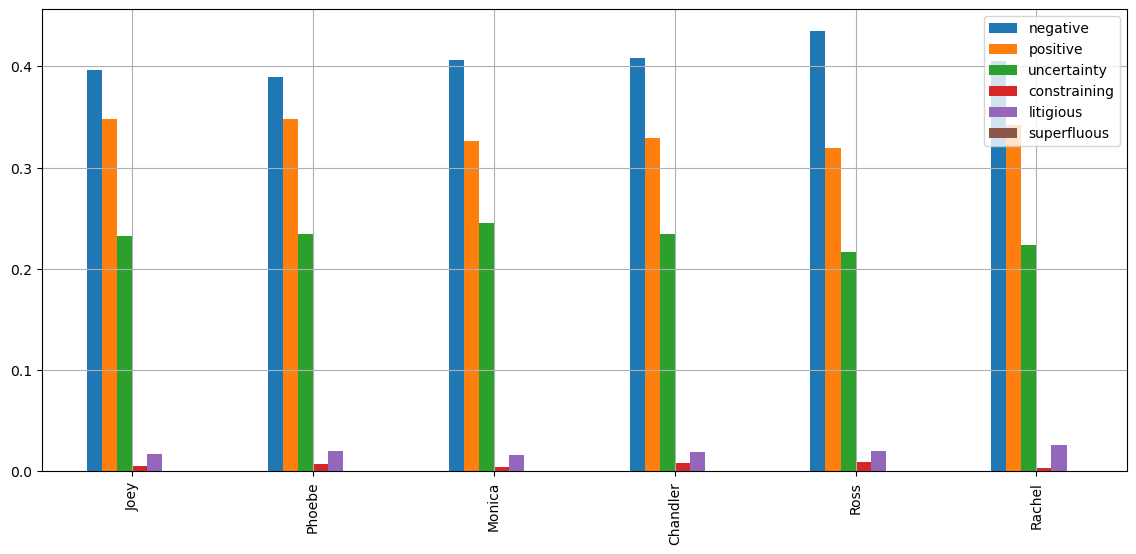

In [34]:
character_emotion_lm = character_emotion_normalized.loc[main_characters+supporting_roles].copy()
character_emotion_lm.loc[main_characters].plot(kind="bar", legend=True, figsize=(14, 6), grid=True)

## 

### NRC

- Each Character's quotes are scored using the NRC sentiment analysis word list.
  - All seasons average score in ['trust', 'fear', 'negative', 'sadness', 'anger', 'surprise',
       'positive', 'disgust', 'joy', 'anticipation']

Emotion ratio definition:

- If the quote contains a word from the NRC list
- quote_count += 1
- author_emotion += 1
- author_emothion_ratio = author_emotion_count / quote_count

In [35]:
# Prepare NRC dictionary
nrc_emotions = nrc[['word', 'sentiment']].copy()
nrc_emotions['word'] = nrc_emotions['word'].str.lower()
nrc_dict = defaultdict(set)
for _, row in nrc_emotions.iterrows():
    nrc_dict[row['word']].add(row['sentiment'])

In [36]:
# Build emotional profile
emotion_categories = sorted(set(nrc_emotions['sentiment']))
character_emotion_counts = defaultdict(lambda: defaultdict(int))

for _, row in quotes_main_characters.iterrows():
    quote = row.get('quote', '')
    if not isinstance(quote, str) or quote.strip().lower() == 'nan':
        continue
    author = row['author']
    words = simple_preprocess(quote)
    for word in words:
        if word in nrc_dict:
            for emotion in nrc_dict[word]:
                character_emotion_counts[author][emotion] += 1

# Emotion DataFrame
character_emotion_df = pd.DataFrame(character_emotion_counts).T.fillna(0)

character_emotion_df = character_emotion_df[character_emotion_df.sum(axis=1) != 0]

character_emotion_normalized = pd.DataFrame(
    character_emotion_df/character_emotion_df.sum(axis=1).values[:, np.newaxis],
    index=character_emotion_df.index,
    columns=character_emotion_df.columns
)




<AxesSubplot:>

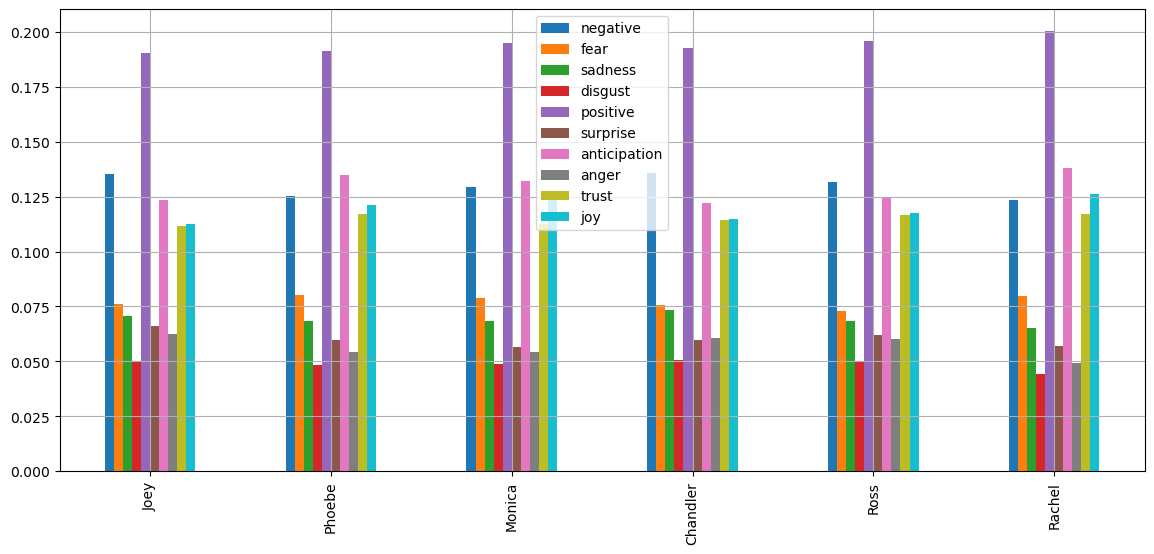

In [37]:
character_emotion_nrc = character_emotion_normalized.loc[main_characters+supporting_roles].copy()
character_emotion_nrc.loc[main_characters].plot(kind="bar", legend=True, figsize=(14, 6), grid=True)

In [38]:
character_emotion_afinn = pd.DataFrame(character_emotion_afinn)
character_emotion_afinn.columns = ["AFINN"]

In [39]:
character_emotion_aggregate = pd.merge(
    character_emotion_afinn,
    character_emotion_nrc,
    left_index=True,
    right_index=True
)
character_emotion_aggregate = pd.merge(
    character_emotion_aggregate,
    character_emotion_bl,
    left_index=True,
    right_index=True
)
character_emotion_aggregate = pd.merge(
    character_emotion_aggregate,
    character_emotion_lm,
    left_index=True,
    right_index=True
)

In [40]:
character_emotion_aggregate

,AFINN,negative_x,fear,sadness,disgust,positive_x,surprise,anticipation,anger,trust,joy,positive_y,negative_y,negative,positive,uncertainty,constraining,litigious,superfluous
Carol,1.481817,0.089069,0.068826,0.048583,0.032389,0.234818,0.052632,0.153846,0.040486,0.125506,0.153846,0.611111,0.388889,0.206897,0.310345,0.413793,0.034483,0.034483,0.000000
Susan,1.323333,0.068966,0.048276,0.041379,0.027586,0.241379,0.082759,0.137931,0.027586,0.137931,0.186207,0.756757,0.243243,0.526316,0.368421,0.105263,0.000000,0.000000,0.000000
Tag,1.292778,0.117647,0.054299,0.054299,0.040724,0.212670,0.076923,0.144796,0.036199,0.117647,0.144796,0.724138,0.275862,0.257143,0.457143,0.200000,0.000000,0.085714,0.000000
Mike,1.262993,0.133621,0.074713,0.050287,0.057471,0.208333,0.060345,0.130747,0.041667,0.107759,0.135057,0.649351,0.350649,0.417391,0.278261,0.295652,0.000000,0.008696,0.000000
David,1.077605,0.099738,0.047244,0.055118,0.047244,0.183727,0.097113,0.167979,0.047244,0.120735,0.133858,0.730263,0.269737,0.338462,0.415385,0.215385,0.000000,0.030769,0.000000
Mrs. Geller,0.984009,0.115625,0.046875,0.075000,0.037500,0.234375,0.065625,0.112500,0.034375,0.128125,0.150000,0.717391,0.282609,0.432432,0.324324,0.243243,0.000000,0.000000,0.000000
Rachel,0.767079,0.123229,0.079836,0.065196,0.044289,0.200116,0.057033,0.137869,0.049239,0.117173,0.126020,0.656495,0.343505,0.405134,0.342158,0.223426,0.003209,0.026073,0.000000
Frank,0.759572,0.138889,0.055556,0.052469,0.046296,0.203704,0.055556,0.169753,0.037037,0.111111,0.129630,0.690909,0.309091,0.297872,0.340426,0.361702,0.000000,0.000000,0.000000
Phoebe,0.705946,0.125071,0.080032,0.068236,0.048482,0.191049,0.059883,0.134609,0.054408,0.117113,0.121120,0.635882,0.364118,0.389080,0.347807,0.234738,0.007739,0.020636,0.000000
Ross,0.666327,0.131538,0.073167,0.068397,0.050241,0.195708,0.061839,0.124763,0.060268,0.116742,0.117338,0.639051,0.360949,0.434526,0.319439,0.216525,0.008853,0.020288,0.000369


In [41]:
emotions_for_clustering = character_emotion_aggregate.copy()

In [69]:
# KMeans clustering
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(emotions_for_clustering.loc[main_characters])
clusters = pd.Series(clusters, index=main_characters, name='Cluster')
#emotions_for_clustering[main_characters, 'Cluster'] = clusters

In [70]:
emotions_for_clustering

,AFINN,negative_x,fear,sadness,disgust,positive_x,surprise,anticipation,anger,trust,joy,positive_y,negative_y,negative,positive,uncertainty,constraining,litigious,superfluous,Cluster
Carol,1.481817,0.089069,0.068826,0.048583,0.032389,0.234818,0.052632,0.153846,0.040486,0.125506,0.153846,0.611111,0.388889,0.206897,0.310345,0.413793,0.034483,0.034483,0.000000,2
Susan,1.323333,0.068966,0.048276,0.041379,0.027586,0.241379,0.082759,0.137931,0.027586,0.137931,0.186207,0.756757,0.243243,0.526316,0.368421,0.105263,0.000000,0.000000,0.000000,4
Tag,1.292778,0.117647,0.054299,0.054299,0.040724,0.212670,0.076923,0.144796,0.036199,0.117647,0.144796,0.724138,0.275862,0.257143,0.457143,0.200000,0.000000,0.085714,0.000000,2
Mike,1.262993,0.133621,0.074713,0.050287,0.057471,0.208333,0.060345,0.130747,0.041667,0.107759,0.135057,0.649351,0.350649,0.417391,0.278261,0.295652,0.000000,0.008696,0.000000,4
David,1.077605,0.099738,0.047244,0.055118,0.047244,0.183727,0.097113,0.167979,0.047244,0.120735,0.133858,0.730263,0.269737,0.338462,0.415385,0.215385,0.000000,0.030769,0.000000,0
Mrs. Geller,0.984009,0.115625,0.046875,0.075000,0.037500,0.234375,0.065625,0.112500,0.034375,0.128125,0.150000,0.717391,0.282609,0.432432,0.324324,0.243243,0.000000,0.000000,0.000000,0
Rachel,0.767079,0.123229,0.079836,0.065196,0.044289,0.200116,0.057033,0.137869,0.049239,0.117173,0.126020,0.656495,0.343505,0.405134,0.342158,0.223426,0.003209,0.026073,0.000000,1
Frank,0.759572,0.138889,0.055556,0.052469,0.046296,0.203704,0.055556,0.169753,0.037037,0.111111,0.129630,0.690909,0.309091,0.297872,0.340426,0.361702,0.000000,0.000000,0.000000,1
Phoebe,0.705946,0.125071,0.080032,0.068236,0.048482,0.191049,0.059883,0.134609,0.054408,0.117113,0.121120,0.635882,0.364118,0.389080,0.347807,0.234738,0.007739,0.020636,0.000000,1
Ross,0.666327,0.131538,0.073167,0.068397,0.050241,0.195708,0.061839,0.124763,0.060268,0.116742,0.117338,0.639051,0.360949,0.434526,0.319439,0.216525,0.008853,0.020288,0.000369,1


In [71]:
clusters

Joey        2
Phoebe      3
Monica      2
Chandler    1
Ross        2
Rachel      0
Name: Cluster, dtype: int32

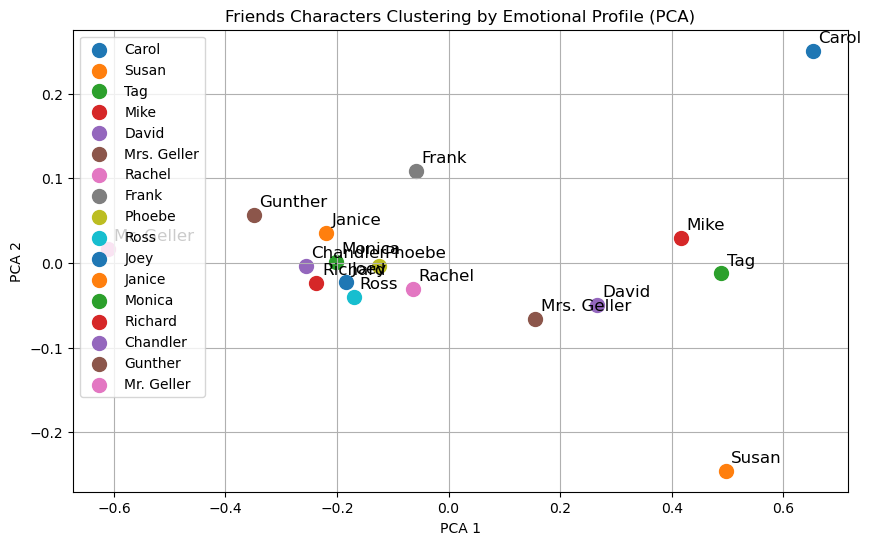

In [43]:
# PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(emotions_for_clustering.drop('Cluster', axis=1))

# Plot
plt.figure(figsize=(10, 6))
for i, character in enumerate(emotions_for_clustering.index):
    x, y = reduced_data[i]
    plt.scatter(x, y, label=character, s=100)
    plt.text(x + 0.01, y + 0.01, character, fontsize=12)

plt.title('Friends Characters Clustering by Emotional Profile (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.legend()
plt.show()